In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import two_col_plot

## Набор данных
- Исходный набор данных из ссылки состоит из 5 различных папок, каждая из которых содержит 100 файлов, где каждый файл представляет отдельного субъекта/человека. Каждый файл представляет запись активности мозга продолжительностью 23,6 секунды.

- Соответствующий временной ряд сэмплирован на 4097 точек данных. Каждая точка данных представляет значение записи ЭЭГ в разные моменты времени. Итак, у нас есть в общей сложности 500 человек, у каждого из которых есть 4097 точек данных продолжительностью 23,5 секунды.

- Мы разделили и перемешали каждые 4097 точек данных на 23 блока, каждый блок содержит 178 точек данных на 1 секунду, и каждая точка данных представляет значение записи ЭЭГ в разные моменты времени.

- Теперь у нас есть 23 x 500 = 11500 информационных фрагментов (строк), каждый из которых содержит 178 точек данных на 1 секунду (столбцы), последний столбец представляет метку y {1,2,3,4,5}.

- Зависимая переменная - это y в столбце 179, объясняющие переменные X1, X2, ..., X178.
- Все записи с классами  2, 3, 4, и 5 не содержат эпилептической активности. Только класс 1 содержит эпилептическую активность.

# Импорт данных

In [12]:
dataset = pd.read_csv('data/Epileptic_Seizure_Recognition.csv')
dataset.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [20]:
# Проверяем на отсутствующие значения
if dataset.isna().any().any():
    print('Присутствуют пропущенные значения')
else:
    print('Пропущенные значения отсутствуют')



Пропущенные значения отсутствуют


Text(0.5, 1.0, 'Распределение классов')

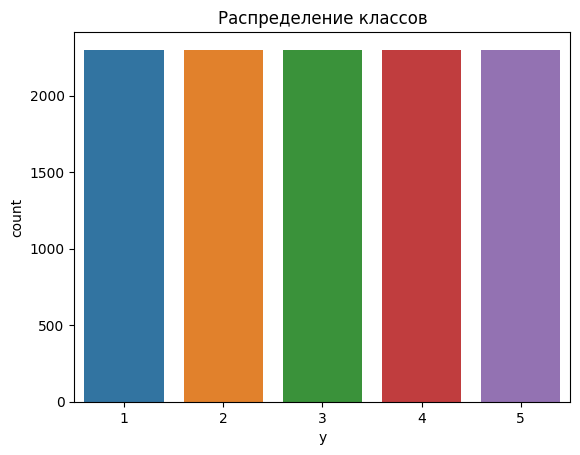

In [21]:
sns.countplot(data=dataset, x='y')
plt.title('Распределение классов')

Как видно, здесь есть 178 признаков ЭЭГ и 5 возможных классов. Основная цель набора данных - правильно идентифицировать эпилептические припадки по данным ЭЭГ, поэтому мы будем выполнять бинарную классификацию между классами с меткой 1 и остальными (2,3,4,5). Чтобы обучить нашу модель, я бинаризую целевую переменную на класс 1  и все остальные - 0.

In [23]:
dataset.loc[dataset['y']>1,'y']=0

Text(0.5, 1.0, 'Распределение классов после бинаризации')

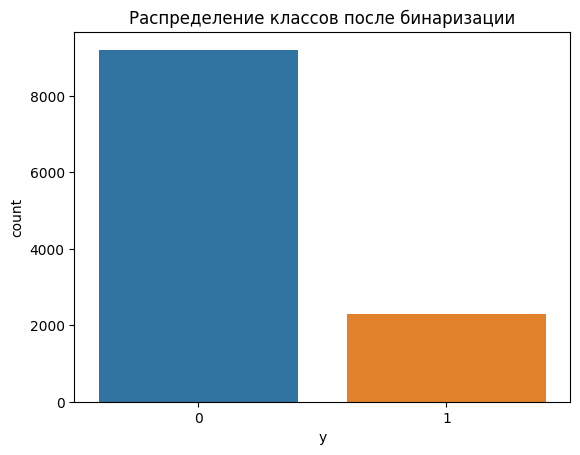

In [24]:
sns.countplot(data=dataset, x='y')
plt.title('Распределение классов после бинаризации')

In [6]:
import random
X = dataset.iloc[:,1:179].values

X.shape

(11500, 178)

## Визуализируетм графики разных классов

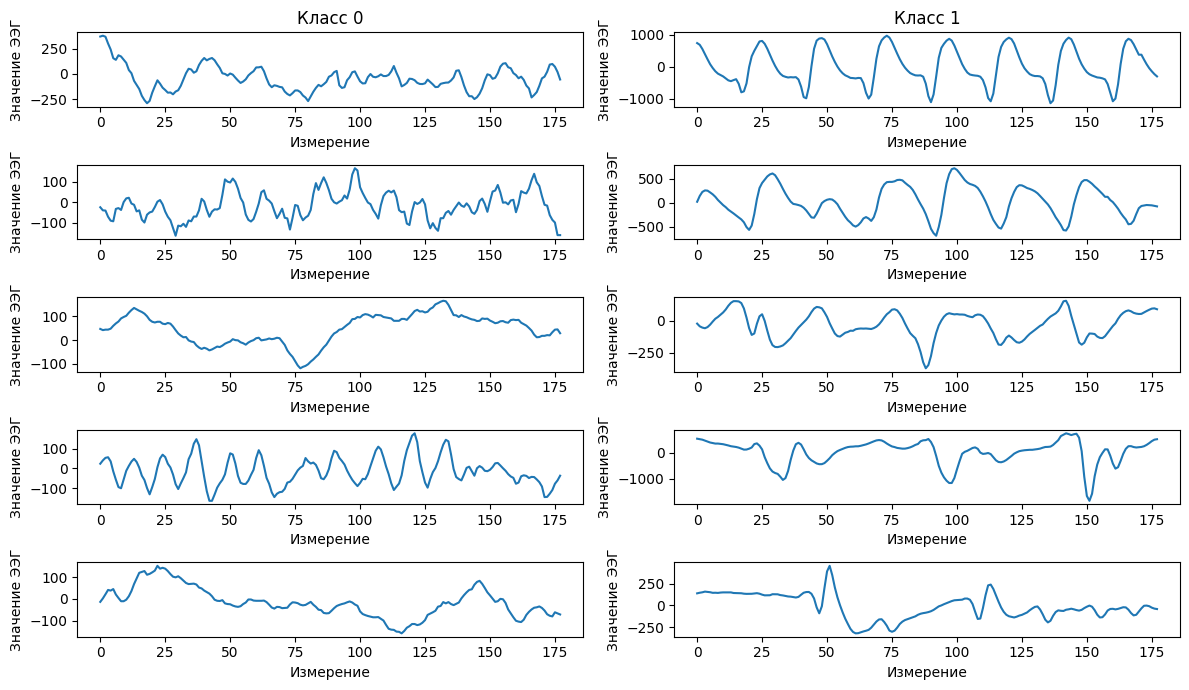

In [25]:
X = dataset.iloc[:,1:179].values
class0_idx = dataset.loc[dataset['y'] == 0].index
class1_idx = dataset.loc[dataset['y'] == 1].index

two_col_plot(X,class0_idx,class1_idx)


In [29]:
print('Mean для класса 1: {}'.format((dataset.iloc[class1_idx].describe().mean()).mean()))
print('Std для класса 1: {}'.format((dataset.iloc[class1_idx].describe().std()).std()))
print('Mean для класса 0: {}'.format((dataset.iloc[class0_idx].describe().mean()).mean()))
print('Std для класса 0: {}'.format((dataset.iloc[class0_idx].describe().std()).std()))


Mean для класса 1: 290.129360958884
Std для класса 1: 53.56315864740058
Mean для класса 0: 1260.098927262616
Std для класса 0: 15.561044289100993


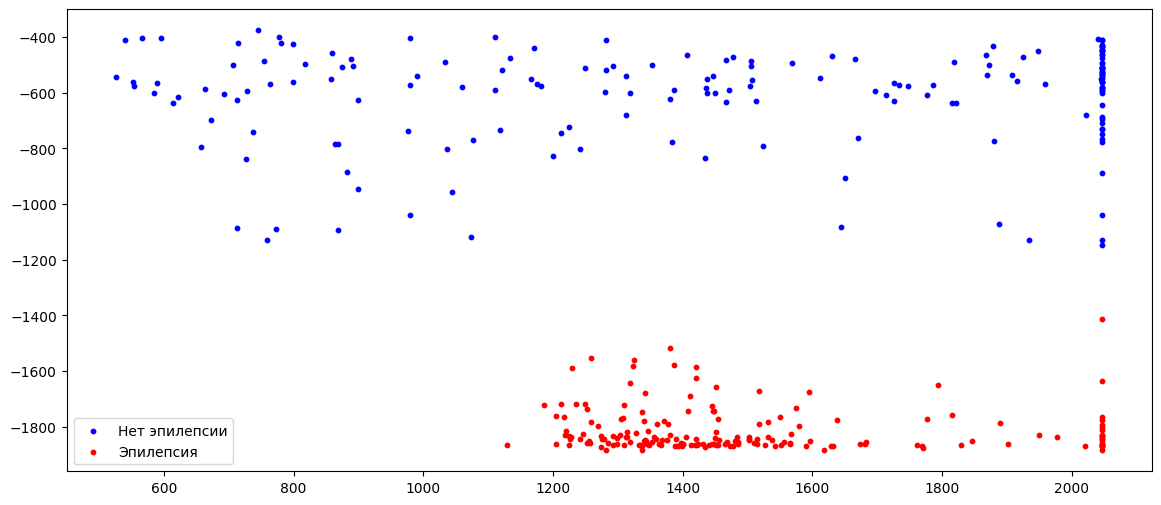

In [38]:
def indic(data):
    """Indicators can be different. In our case we use just min and max values
    Additionally, it can be mean and std or another combination of indicators"""
    max = np.max(data, axis=1)
    min = np.min(data, axis=1)
    return max, min

not_epileptic = [dataset.iloc[class0_idx].iloc[:, range(1, len(dataset.columns)-1)].values]
epileptic = [dataset.iloc[class1_idx].iloc[:, range(1, len(dataset.columns)-1)].values]

x1,y1 = indic(not_epileptic)
x2,y2 = indic(epileptic)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, s=10, c='b', label='Нет эпилепсии')
ax1.scatter(x2, y2, s=10, c='r', label='Эпилепсия')
plt.legend(loc='lower left');
plt.show()

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

# Создание экземпляра StratifiedShuffleSplit с указанием количества разбиений и размера тестового набора
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
X = dataset.iloc[:,1:179].values
y = dataset['y'].values

# Разделение данных на обучающий и тестовый наборы
for train_index, test_index in ss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


# Бейзлайн

В качестве базовых моделей будем использовать классификаторы SVM и RandomForest

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer

# Создание pipeline с нормализацией и классификатором SVM
pipelineSVM = Pipeline([
    ('scaler', StandardScaler()),  # Нормализация данных
    ('svm', SVC())  # Классификатор SVM
])

# Создание pipeline с нормализацией и классификатором RandomForest
pipelineRF = Pipeline([
    ('scaler', StandardScaler()),  # Нормализация данных
    ('RF', RandomForestClassifier(n_estimators=50, random_state = 7575))  # Классификатор RandomForest
])


In [50]:
# Обучение модели
pipelineSVM.fit(X_train, y_train)

# Прогнозирование классов для новых данных
y_pred = pipelineSVM.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1840
           1       0.95      0.90      0.92       460

    accuracy                           0.97      2300
   macro avg       0.96      0.94      0.95      2300
weighted avg       0.97      0.97      0.97      2300



In [51]:
confusion_matrix(y_test,y_pred)

array([[1820,   20],
       [  47,  413]])

In [52]:
# Обучение модели
pipelineRF.fit(X_train, y_train)

# Прогнозирование классов для новых данных
y_pred = pipelineRF.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.95      0.94      0.95       460

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.97      2300
weighted avg       0.98      0.98      0.98      2300



In [53]:
confusion_matrix(y_test,y_pred)

array([[1817,   23],
       [  27,  433]])

## FFT и Wavelet признаки
#### Wavelets

In [58]:
import numpy as np
import pywt

def extract_wavelet_features(data, labels, waveletname):
    # Извлечение вейвлет-признаков
    wavelet_features = []
    for signal in data:
        signal_features = []
        for coeff in pywt.wavedec(signal, waveletname):
            signal_features += coeff.tolist()
        wavelet_features.append(signal_features)
    return wavelet_features    

waveletname = 'db4'  # Имя вейвлета для разложения
wavelet_features = extract_wavelet_features(X, y, waveletname)
# Преобразование данных в массив numpy
Xw = np.array(wavelet_features)


# Разделение данных на обучающий и тестовый наборы
for train_index, test_index in ss.split(Xw, y):
    X_train, X_test = Xw[train_index], Xw[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Создание pipeline с нормализацией и классификатором SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Нормализация данных
    ('RF', RandomForestClassifier(n_estimators=50, random_state = 7575))  # Классификатор SVM
])

# Обучение модели
pipeline.fit(X_train, y_train)


# Оценка модели на тестовом наборе
accuracy = pipeline.score(X_test, y_test)
y_pred = pipeline.predict(X_test)
print("Точность классификатора: {:.2f}".format(accuracy))
print(classification_report(y_test, y_pred))

Точность классификатора: 0.97
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1840
           1       0.94      0.92      0.93       460

    accuracy                           0.97      2300
   macro avg       0.96      0.95      0.96      2300
weighted avg       0.97      0.97      0.97      2300



In [59]:
confusion_matrix(y_test,y_pred)

array([[1811,   29],
       [  36,  424]])

#### FFT

In [63]:
from scipy.fft import fft

def extract_fft_features(data, labels):
    # Извлечение признаков на основе FFT
    fft_features = []
    for signal in data:
        fft_result = fft(signal)
        fft_features.append(np.abs(fft_result[:len(signal)//2]))
    return fft_features

fft_features=extract_fft_features(X, y)
# Преобразование данных в массив numpy
X_fft = np.array(fft_features)


# Разделение данных на обучающий и тестовый наборы
for train_index, test_index in ss.split(X_fft, y):
    X_train, X_test = X_fft[train_index], X_fft[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Создание pipeline с нормализацией и классификатором SVM
pipeline_fft = Pipeline([
    ('scaler', StandardScaler()),  # Нормализация данных
    ('RF', RandomForestClassifier(n_estimators=50, random_state = 7575))  # Классификатор SVM
])

# Обучение модели
pipeline_fft.fit(X_train, y_train)


# Оценка модели на тестовом наборе
accuracy = pipeline_fft.score(X_test, y_test)
y_pred = pipeline_fft.predict(X_test)
print("Точность классификатора : {:.2f}".format(accuracy))
print(classification_report(y_test, y_pred))


Точность классификатора : 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.94      0.96      0.95       460

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



In [64]:
confusion_matrix(y_test,y_pred)

array([[1813,   27],
       [  19,  441]])

## Автоматически сгенерированные признаки 
#### Библиотека tslearn

In [148]:
from tslearn import utils as ts_utils
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh import extract_features, select_features


def extract_features_tsfresh(data, labels):
    tsf_settings = EfficientFCParameters()
    # Disable tqdm progress bar
    tsf_settings.disable_progressbar = True
    # Преобразование данных в требуемый формат tslearn
    lst=[]
    for i in range(X.shape[0]):
        col=pd.DataFrame(ts_utils.to_time_series(X[i]))
        col['id']=i
        lst.append(col)
    df=pd.concat(lst)
    df=df.reset_index()
    df.columns=['time','val','id']
    df.set_index('id')

    # Извлечение признаков с помощью tsfresh
    extracted_features = extract_features(df, column_id="id", column_sort="time", default_fc_parameters=tsf_settings)
    return extracted_features

tsfresh_features=extract_features_tsfresh(X, y)
# Удаляем значения nan и оставляем наиболее релевантные признаки
tsfresh_features=tsfresh_features.dropna(axis=1)
X_selected = select_features(tsfresh_features, pd.Series(y))
# Преобразование данных в массив numpy
X_tsfresh = np.array(X_selected)


# Разделение данных на обучающий и тестовый наборы
for train_index, test_index in ss.split(X_tsfresh, y):
    X_train, X_test = X_tsfresh[train_index], X_tsfresh[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Создание pipeline с нормализацией и классификатором SVM
pipeline_tsfresh = Pipeline([
    ('scaler', StandardScaler()),  # Нормализация данных
    ('RF', RandomForestClassifier(n_estimators=50, random_state = 7575))  # Классификатор SVM
])

# Обучение модели
pipeline_tsfresh.fit(X_train, y_train)


# Оценка модели на тестовом наборе
accuracy = pipeline_tsfresh.score(X_test, y_test)
y_pred = pipeline_tsfresh.predict(X_test)
print("Точность классификатора : {:.2f}".format(accuracy))
print(classification_report(y_test, y_pred))

Feature Extraction: 100%|██████████| 60/60 [01:27<00:00,  1.47s/it]


Точность классификатора : 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1840
           1       0.98      0.97      0.98       460

    accuracy                           0.99      2300
   macro avg       0.99      0.98      0.99      2300
weighted avg       0.99      0.99      0.99      2300



In [149]:
confusion_matrix(y_test,y_pred)

array([[1833,    7],
       [  13,  447]])

# Резюме

Модель основанная на признаках сгенерированных библиотекой tsfresh показала наилучшие метрики на этом датасете.